In [1]:
# possibly used packages
using QuadGK,LaTeXStrings,BenchmarkTools;
using LinearAlgebra,Roots;
using Plots;
default(framestyle = :box, minorticks = 5, size=(400,300));

In [2]:
include("src/gem.jl");
using Main.Gem;

# Introduction
This notebook illustrates how to solve the following Coupled-channel Schrodinger equation using Gaussian-Expansion-Method as described in [Gaussian expansion method for few-body systems](https://www.sciencedirect.com/science/article/abs/pii/S0146641003900159?via%3Dihub).
\begin{equation}
[-\frac{\hbar^2}{2\mu_i}\bigtriangledown^2+\Delta E_i]\psi_i(\vec{r})+\sum_j V_{ij}\psi_j(\vec{r})=E\psi_i(\vec{r})
\end{equation}
or radially,i.e. $u_i(r)=r \psi_i(r)$,
\begin{equation}
[-\frac{\hbar^2}{2\mu_i}\frac{d^2}{dr^2}+\frac{\hbar^2l_i(l_i+1)}{2\mu_ir^2}+\Delta E_i]u_i+\sum_j V_{ij}u_j=Eu_i
\end{equation}
For a better understanding, the necessary ingredients will be explained next!

If we expand the wave function with given basis(we choose Gaussian basis functions here), i.e.
\begin{align}
\psi^{(i)}_{lm}(\vec{r})&=\sum_{n=1}^{n_{max}}c^{(i)}_{nl}\phi_{nlm}^{(i)}(\vec{r})\\
\phi_{nlm}^{(i)}(\vec{r})&=\phi_{nl}^{(i)}(r)Y_{lm}({\hat{r}})\\
\phi_{nl}^{(i)}(r)&=N_{nl_i}r^{l_i}e^{-\nu_n r^2}\\
N_{nl_i}&=(\frac{2^{l_i+2}(2\nu_n)^{l_i+3/2}}{\sqrt{\pi}(2l_i+1)!!})^{1/2}
\end{align}
In practice, the set of Gaussian size parameters($\nu_i$) works well when in geometric progression
\begin{align}
\nu_n&=\frac{1}{r_n^2}\\
r_n&=r_1a^{n-1}\\
\Rightarrow \nu_n&=\frac{1}{r_1^2}(\frac{r_1}{r_{n_{max}}})^{\frac{2(n-1)}{n_{max}-1}}
\end{align}
Thus, we adopt three parameters $\{n_{max},r_1,r_{n_{max}}\}$ to represent the gaussian basis set. 

Under such a basis, the Coupled-Channel Schrodinger equation turns to be a generalized matrix eigenvalue problem:
\begin{align}
\left[\begin{pmatrix}\Box^{(1)}& & \\&... &\\ & & \Box^{(n)}\end{pmatrix}
+\begin{pmatrix}\bigstar^{(11)}&...&..\\...&...&...\\...&...&\bigstar^{(nn)}\end{pmatrix}
+\begin{pmatrix}\Delta E_1\cdot \blacksquare^{(1)}& & \\&... &\\ & &\Delta E_n\cdot \blacksquare^{(n)}\end{pmatrix}\right]
\begin{pmatrix}c_1^{(1)}\\...\\c_{n_{nmax}}^{(n)}\end{pmatrix}=E\begin{pmatrix}c_1^{(1)}\\...\\c_{n_{nmax}}^{(n)}\end{pmatrix}
\end{align}

where $\Box$, $\bigstar$ and $\blacksquare$ refer to the submatrix of T- , V- and N matrix with their elements specified in the following,

\begin{align}
\Box^{(i)}_{n,n'}&=\langle\phi_{nlm}^G|-\frac{\hbar^2}{2\mu_i}\bigtriangledown^2|\phi_{n'lm}^G\rangle=\frac{\hbar^2}{\mu_i}\frac{(2l_i+3)\nu_n\nu_{n'}}{\nu_n+\nu_{n'}}(\frac{2\sqrt{\nu_n\nu_{n'}}}{\nu_n+\nu_{n'}})^{l_i+3/2}\\
\bigstar^{(ij)}_{n,n'}&=\langle\phi_{nlm}^G|V^{(ij)}|\phi_{n'lm}^G\rangle=N_{nl_i}N_{n'l_i}\int_0^{\infty}r^{2l_i}e^{-(\nu_n+\nu_{n'})r^2}V^{(ij)}(r)r^2dr\\
\blacksquare^{(i)}_{n,n'}&=\langle\phi_{nlm}^G|\phi_{n'lm}^G\rangle=(\frac{2\sqrt{\nu_n\nu_{n'}}}{\nu_n+\nu_{n'}})^{l_i+3/2}
\end{align}

## To use the script
1. **define your coupled-channel potential in the form**
    ```julia
    function potential(r,i,j;args1=...,args2=...)
    #some codes
    end
    ```
where the i,j are the channel number. remember to put all extra arguments into the optinal part.

2. **input the least information of your Schrodinger equation**

    Gaussian basis: *GemBasis*($n_{max}$ , $r_1$ , $r_{nmax}$)

    Hamiltonian: *GemHamiltonian*([$\mu_1$,...,$\mu_n$],[$\Delta E_1$,...,$\Delta E_n$],[$l_1$ ,..., $l_n$],potential)

    Hamiltonian model in GEM: *GemModel*(::GemHamiltonian,::GemBasis;hbar=...)






3. **solve the model**

    *gemsolve!(::GemModel,::GemHamiltonian,::GemBasis;args1=...,args2=...)*
4. **find out if there's a bound state**

    gemisbounded(::GemModel)
5. **ploting the result**

    *gemplot(::GemModel,::GemHamiltonian,::GemBasis,cl,index,rmin,rmax;kwargs...)* (cl is the cl-th channel, index is the index of eigenvalues of the above matrix equation), *gemplot!*,*gemplotr*,*gemplotr!*
6. **get the explicit wave function**

    *gemgetwf(::GemModel,::GemHamiltonian,::GemBasis,index)* will return the vector of callable wavefunction for all channels

# Examples

In the following, we take two examples from the above paper for an illustration.

## Test for $^4He$ atomic dimer

In [3]:
function potential_4he(r,i,j)
    rm,ϵ,A,α,C6,C8,C10,D=2.9673,10.6,0.5448504e6,13.353384,1.3732412,0.4253785,0.178100,1.241314
    F(x)=(x<D) ? exp(-(D/x-1)^2) : 1
    if i==1&&j==1 #only for single-channel
        x=r/rm
        return ϵ*(A*exp(-α*x)-(C6/x^6+C8/x^8+C10/x^10)*F(x))
    end
    return 0.0
end

potential_4he (generic function with 1 method)

In [4]:
gb_4he=GemBasis(60,0.14,700.0)
gh_4he=GemHamiltonian([1.0],[0.0],[0],potential_4he)
gm_4he=GemModel(gh_4he,gb_4he;hbar=sqrt(2*12.119303326402733));

In [5]:
gemsolve!(gm_4he,gh_4he,gb_4he)

In [6]:
gemisbounded(gm_4he)

true

In [7]:
gm_4he.evals[1:10]

10-element Vector{ComplexF64}:
   -8.67117395614727e-6 + 0.0im
   5.367551461241194e-5 + 0.0im
 0.00017197787786013568 + 0.0im
  0.0003605108229724534 + 0.0im
  0.0006337286999609788 + 0.0im
  0.0010132890070078612 + 0.0im
  0.0015299361612454408 + 0.0im
  0.0022264024475501013 + 0.0im
  0.0031608176175915064 + 0.0im
   0.004411961849857112 + 0.0im

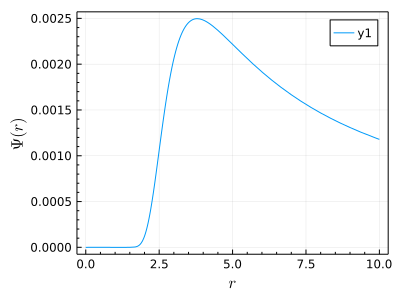

In [8]:
gemplot(gm_4he,gh_4he,gb_4he,1,1,0,10;legend=:topright,xlabel=L"r",ylabel=L"\Psi(r)")

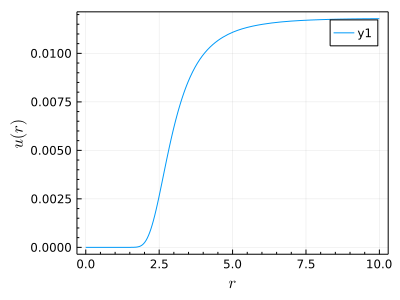

In [9]:
gemplotr(gm_4he,gh_4he,gb_4he,1,1,0,10;legend=:topright,xlabel=L"r",ylabel=L"u(r)")

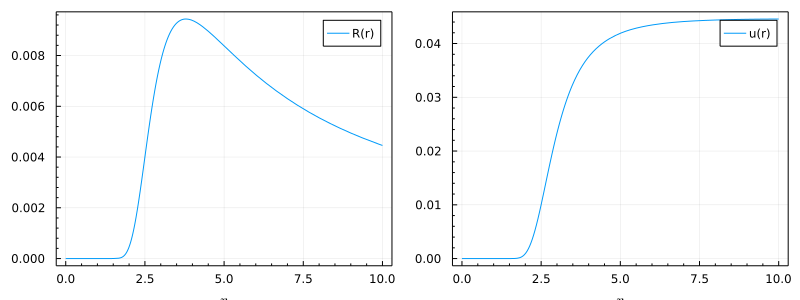

In [10]:
let 
    wfs=gemgetwf(gm_4he,gh_4he,gb_4he,1)

    p1=plot(legend=:topright,xlabel=L"r")
    for i in eachindex(wfs)
        plot!(r->wfs[i](r),0,10,label="R(r)")
    end
    p2=plot(legend=:topright,xlabel=L"r")   
    for i in eachindex(wfs)
        plot!(r->r*wfs[i](r),0,10,label="u(r)")
    end

    plot(p1,p2,layout=(1,2),size=(800,300))
end

## Test for deuteron

In [11]:
function potential_deuteron(r,i,j)
    if i==1&&j==1 #only for single-channel
        return (-626.885*exp(-1.55*r)+1438.72*exp(-3.11*r))/r
    end
    return 0.0
end

potential_deuteron (generic function with 1 method)

In [12]:
gb_deuteron=GemBasis(30,0.1,30.0)
gh_deuteron=GemHamiltonian([1.0],[0.0],[0],potential_deuteron)
gm_deuteron=GemModel(gh_deuteron,gb_deuteron;hbar=sqrt(2*41.47));

In [14]:
gemsolve!(gm_deuteron,gh_deuteron,gb_deuteron)

In [15]:
gemisbounded(gm_deuteron)

true

In [16]:
gm_deuteron.evals[1:10]

10-element Vector{ComplexF64}:
 -2.2306068259127647 + 0.0im
 0.07698885449141406 + 0.0im
  0.3199178133569287 + 0.0im
   0.767423870901172 + 0.0im
  1.4930713897362642 + 0.0im
   2.619720600396012 + 0.0im
  4.3418749692654375 + 0.0im
   6.960495909473995 + 0.0im
  10.936368570246268 + 0.0im
  16.973005843273793 + 0.0im

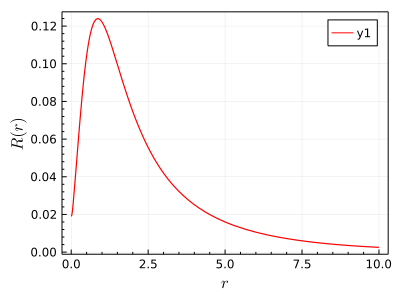

In [17]:
gemplot(gm_deuteron,gh_deuteron,gb_deuteron,1,1,0,10;color="red",lw=1.2,legend=:topright,xlabel=L"r",ylabel=L"R(r)")

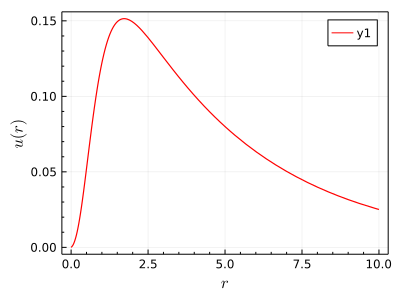

In [18]:
gemplotr(gm_deuteron,gh_deuteron,gb_deuteron,1,1,0,10;color="red",lw=1.2,legend=:topright,xlabel=L"r",ylabel=L"u(r)")

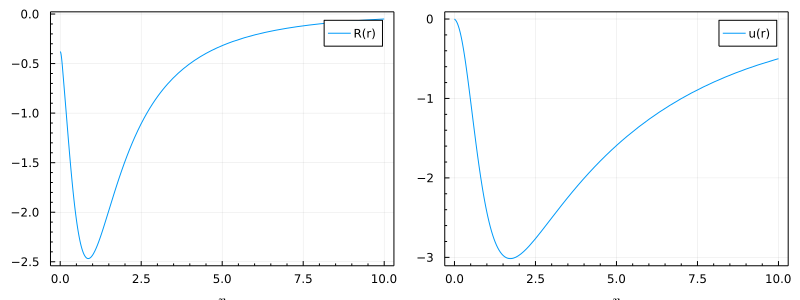

In [19]:
let 
    wfs=gemgetwf(gm_deuteron,gh_deuteron,gb_deuteron,1)

    p1=plot(legend=:topright,xlabel=L"r")
    for i in eachindex(wfs)
        plot!(r->wfs[i](r),0,10,label="R(r)")
    end
    p2=plot(legend=:topright,xlabel=L"r")   
    for i in eachindex(wfs)
        plot!(r->r*wfs[i](r),0,10,label="u(r)")
    end

    plot(p1,p2,layout=(1,2),size=(800,300))
end

there is an **extra** minus sign directly from the coefficients in this case.

# Try it yourself!